In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

from sklearn.metrics import *
import scikitplot as skplt

from functools import partial
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
data = pd.read_csv('D:/semester3/test1_200/output_test.csv')
img_dir = 'D:/semester3/test1_200/'
class_names = ['benign', 'malignant']

In [3]:
data

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
...,...,...,...,...
39540,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...
39541,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...
39542,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...
39543,5,400,test,BreaKHis_v2/histology_slides/breast/malignant/...


In [4]:
data = data.loc[data['mag'] == 200] 

In [5]:
data

,fold,mag,grp,filename
30,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
31,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
32,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
33,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
34,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...
...,...,...,...,...
39506,5,200,test,BreaKHis_v2/histology_slides/breast/malignant/...
39507,5,200,test,BreaKHis_v2/histology_slides/breast/malignant/...
39508,5,200,test,BreaKHis_v2/histology_slides/breast/malignant/...
39509,5,200,test,BreaKHis_v2/histology_slides/breast/malignant/...


In [6]:
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(3)

,fold,mag,grp,path,label,label_int,filename
30,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-200-001.png
31,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-200-002.png
32,1,200,train,BreaKHis_v2/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-200-003.png


In [7]:
data.to_csv('D:/semester3/test1_200/updated_fold_200.csv')

In [8]:
data_updated_200 = pd.read_csv('D:/semester3/test1_200/updated_fold_200.csv')

Count of Benign    :  3115
Count of Malignant :  6950


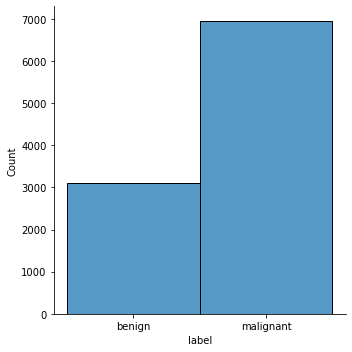

In [9]:
ax = sns.displot(data=data_updated_200, x=data_updated_200['label'])
print('Count of Benign    : ', data_updated_200[data_updated_200.label == 'benign'].label.count())
print('Count of Malignant : ', data_updated_200[data_updated_200.label == 'malignant'].label.count())

In [10]:
test_df = data_updated_200.groupby('label').sample(frac=0.2)
train_df = data_updated_200.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# split training and validation set
valid_df = train_df.sample(frac=0.1)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df['set'] = 'test'
train_df['set'] = 'train'
valid_df['set'] = 'valid'
data_new = pd.concat([train_df,valid_df, test_df])
print(data_new)

# ax = sns.displot(data=data_new, x='label', col='set')

print('Training set')
print(train_df.label.value_counts())

print('\nValidation set')
print(valid_df.label.value_counts())

print('\nTest set')
print(test_df.label.value_counts())

      Unnamed: 0  fold  mag    grp  \
0             30     1  200  train   
1             32     1  200  train   
2             33     1  200  train   
3             34     1  200  train   
4             35     1  200  train   
...          ...   ...  ...    ...   
2008       14777     2  200   test   
2009       35152     5  200  train   
2010       27686     4  200  train   
2011       39399     5  200   test   
2012       19270     3  200  train   

                                                   path      label  label_int  \
0     BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
1     BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
2     BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
3     BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
4     BreaKHis_v2/histology_slides/breast/benign/SOB...     benign          0   
...                                                 ...  

In [11]:
print(train_df.label.value_counts())

malignant    5011
benign       2236
Name: label, dtype: int64


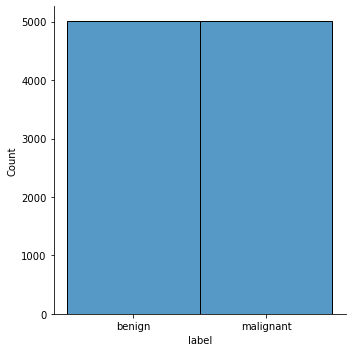

In [12]:
# upsampling training dataset
max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x=train_df['label'])

In [13]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))
test_loader=tf.data.Dataset.from_tensor_slices((img_dir+test_df.path, test_df.label_int))

In [14]:
model_handle_map = {

 "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

}


model_image_size_map = {

 "efficientnet_b0": 224

}

In [15]:
model_name = 'efficientnet_b0'
model_handle = model_handle_map.get(model_name)
IMAGE_SIZE = model_image_size_map.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_df)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnet_b0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Input size 224


In [16]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

In [17]:
def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])/255
    return img, label

In [18]:
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))

train_ds = (
    train_loader.shuffle(len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
#     .map(partial(augmentor),num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)
valid_ds = (
    valid_loader.shuffle(len(valid_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [19]:
def view_image(ds, col=8, row=2, size=(25,7)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for images, labels in ds.take(1):
        for i in range(col*row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

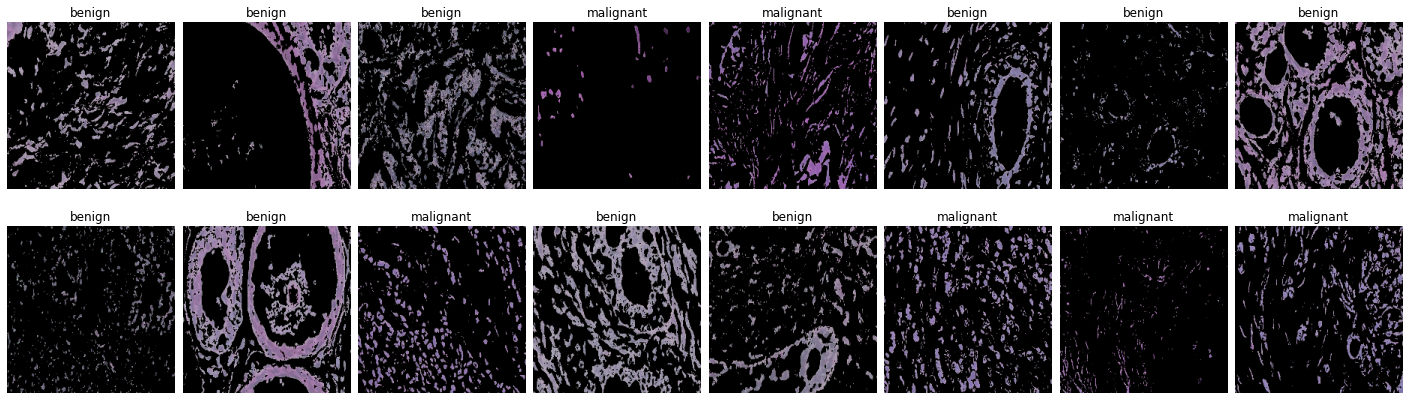

In [20]:
view_image(train_ds)

In [21]:
def build_network(image_size):
    print('building model...')
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base_model'),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid', name='classifier') 
    ],name=model_name)
    model.build((None, image_size, image_size, 3))
    model.summary()
    print('model loaded!!!')
    return model

In [22]:
tf.keras.backend.clear_session()
model = build_network(IMAGE_SIZE)

building model...
Model: "efficientnet_b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_model (KerasLayer)     (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                 

In [23]:
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model_40.h5", save_best_only=True)
checkpoint_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=1e-03,  maximal_learning_rate=7e-3, 
    step_size=3*(SAMPLE_SIZE//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),

]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler) , 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
)

history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [checkpoint_cb],
    validation_data=valid_ds,
)

Epoch 1/12
157/157 [==============================] - 2554s 16s/step - loss: 0.7480 - accuracy: 0.6836 - precision: 0.6842 - recall: 0.6819 - auc: 0.7485 - val_loss: 0.9736 - val_accuracy: 0.3366 - val_precision: 0.8571 - val_recall: 0.0328 - val_auc: 0.7546
Epoch 2/12
157/157 [==============================] - 2691s 17s/step - loss: 0.5226 - accuracy: 0.8281 - precision: 0.8190 - recall: 0.8423 - auc: 0.9067 - val_loss: 0.9357 - val_accuracy: 0.5130 - val_precision: 0.9701 - val_recall: 0.2951 - val_auc: 0.9012
Epoch 3/12
157/157 [==============================] - 2550s 16s/step - loss: 0.3896 - accuracy: 0.8963 - precision: 0.8908 - recall: 0.9034 - auc: 0.9626 - val_loss: 0.5546 - val_accuracy: 0.7888 - val_precision: 0.9847 - val_recall: 0.7013 - val_auc: 0.9708
Epoch 4/12
157/157 [==============================] - 3667s 23s/step - loss: 0.3025 - accuracy: 0.9380 - precision: 0.9369 - recall: 0.9393 - auc: 0.9851 - val_loss: 0.2539 - val_accuracy: 0.9578 - val_precision: 0.9813 - v

In [24]:
def training_history(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(history['loss']))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    return None

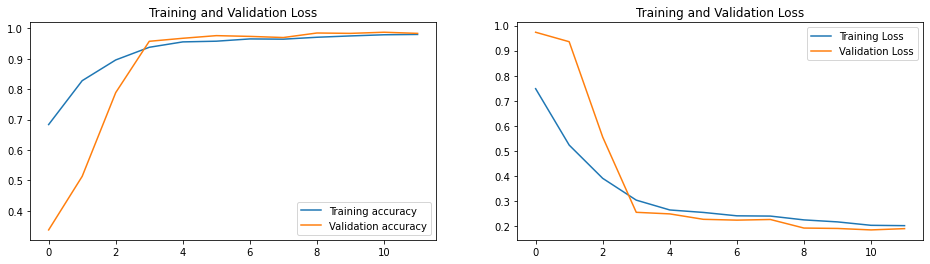

In [25]:
training_history(history.history)

In [26]:
def decode_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])/255
    return img

1/1 [==============================] - 522s 522s/step
              precision    recall  f1-score   support

      benign       0.94      0.99      0.96       623
   malignant       1.00      0.97      0.98      1390

    accuracy                           0.98      2013
   macro avg       0.97      0.98      0.97      2013
weighted avg       0.98      0.98      0.98      2013

f1_score        : 0.977645305514158
accuracy_score  : 0.977645305514158
precision_score  : 0.9970436067997044
recall_score  : 0.9705035971223022


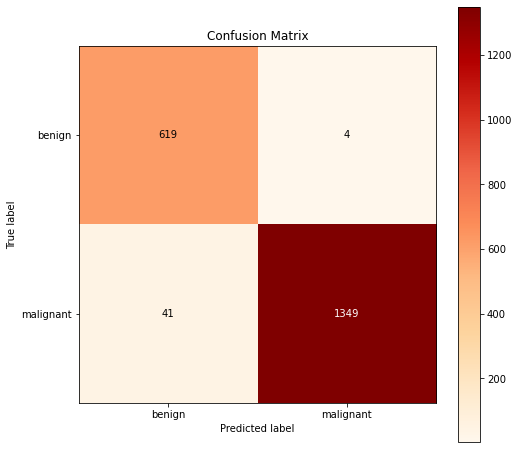

In [27]:
test_df = test_df.reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))
print('precision_score  :', precision_score(test_index, pred_index))
print('recall_score  :', recall_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False,cmap="OrRd")

In [28]:
print('f1_score        :', f1_score(test_index, pred_index))

f1_score        : 0.9835946044476851


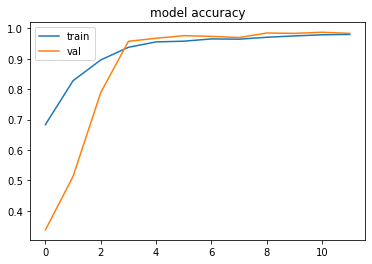

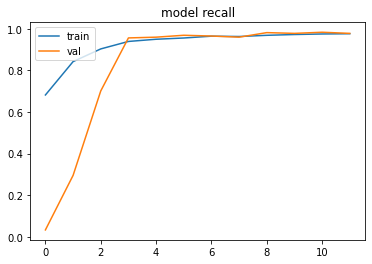

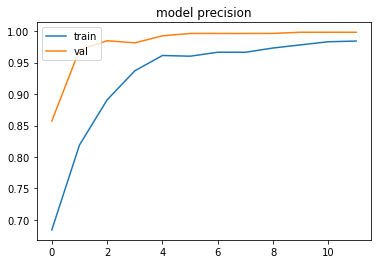

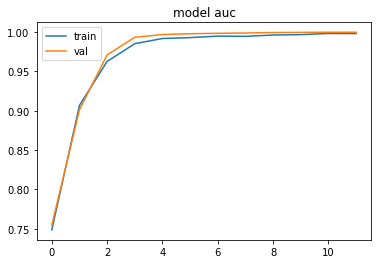

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plt.plot(history.history['f1_score'])
#plt.plot(history.history['val_f1_score'])
#plt.title('model f1_score')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()